In [1]:
from pathlib import Path
from plots import plot_clusters
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from poll_processing import execute_pipeline, init_spark
from run_algorithms import run_collaborative_filtering, run_kmeans, round_cf_df

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

directories = [
    str(Path().resolve().parent) + "/data/poll_data.csv",
    str(Path().resolve().parent) + "/data/questions.json",
    str(Path().resolve().parent) + "/data/df_indexes.csv",
]

spark = init_spark()
df_indexes = execute_pipeline(spark, directories)

df_indexes_pd = df_indexes.toPandas()

c:\Users\palaz\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Pipeline

### The source .csv

In [2]:
pd.read_csv('../data/poll_data.csv').head(5)

,Informazioni cronologiche,Ho letto e accettato l'informativa e confermo inoltre di avere più di 18 anni,Quanti anni hai?,Genere,Da quante persone è composto il tuo nucleo familiare?,Occupazione,Quanto è grande la tua azienda?,Da che regione provieni?,Provincia di provenienza,In che regione lavori/studi?,...,Rifiuti - Lavoro o Università [C'è un'attenzione nel ridurre l'uso della plasica],Rifiuti - Lavoro o Università [C'è un'attenzione alla gestione di materiali organici],Rifiuti - Lavoro o Università [C'è un'attenzione alla gestione di materiali inorganici],"Rifiuti - Casa [Vengono implementate le 3R: Riduzione, Riuso e Riciclo]",Rifiuti - Casa [C'è un'attenzione nel ridurre l'uso della plasica],Rifiuti - Casa [C'è un'attenzione alla gestione di materiali organici],Rifiuti - Casa [C'è un'attenzione alla gestione di materiali inorganici],"Inserire il numero di eventi (conferenze, workshop, sensibilizzazione, formazione pratica, festival, etc.) legati ai problemi di sostenibilità e dell'ambiente organizzati dalla propria azienda e/o università (media per anno degli ultimi 3 anni). Selezionare una delle seguenti opzioni:","Inserire il numero totale di attività organizzate dalle organizzazioni studentesche o da eventuali organizzazioni interne al proprio ambiente di lavoro per anno. Ad esempio, seminari, webinars, formazione, eventi sportivi, bazaar di materiali riciclati, comunità di divulgazione, etc.. Selezionare una delle seguenti opzioni:","La presenza di strutture green all'interno del proprio campus e/o della propria azienda che siano accessibili al pubblico, per esempio durante attività culturali, indicano un impatto più ampio di tali strutture nei loro dintorni (Festival Culturali, teatro, performance musicali, esibizioni, attività virtuali, etc.). Selezionare una delle seguenti opzioni:"
2023/06/18 1:13:56 PM EEST,Sì,Tra 26 e 50 anni,Femminile,4,Non impiegato,Da 51 a 250 impiegati (media impresa),Sicilia,Messina,Sicilia,Messina,...,1-50%,51-75%,In Progetto,In Progetto,1-50%,In Progetto,1 - 4,3 - 4,1 evento per anno,NaN
2023/06/18 2:46:14 PM EEST,Sì,Maggiore di 50 anni,Femminile,4,Lavoratore presso azienda pubblica,Da 51 a 250 impiegati (media impresa),Sicilia,Messina,Sicilia,Messina,...,76-100%,76-100%,76-100%,76-100%,76-100%,76-100%,1 - 4,1 - 2,3 eventi per anno,NaN
2023/06/18 3:09:21 PM EEST,Sì,Tra 26 e 50 anni,Maschile,3,Lavoratore presso azienda privata,Da 1 a 10 impiegati (micro impresa),Sicilia,Messina,Sicilia,Messina,...,1-50%,1-50%,1-50%,1-50%,1-50%,1-50%,0,0,Nessuna,NaN
2023/06/18 4:17:34 PM EEST,Sì,Tra 18 e 25 anni,Femminile,4,Studente Lavoratore,Da 1001 a 10000 impiegati,Sicilia,Messina,Sicilia,Messina,...,76-100%,76-100%,76-100%,76-100%,76-100%,76-100%,5 - 17,1 - 2,2 eventi per anno,NaN
2023/06/18 4:46:22 PM EEST,Sì,Tra 26 e 50 anni,Femminile,4,Non impiegato,Da 1001 a 10000 impiegati,Sicilia,Messina,Sicilia,Messina,...,No,No,1-50%,In Progetto,1-50%,1-50%,0,0,Nessuna,NaN


### From .csv to scores

In [3]:
pd.read_csv('../data/df_scores.csv').iloc[:, 2:].head()

,S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9,V_10,...,wastew2,wastew3,wastew4,wasteh1,wasteh2,wasteh3,wasteh4,ER_1,ER_2,ER_3
0,37.5,37.5,0.0,49.5,99.0,150.0,99.0,99.0,50.0,37.5,...,100.0,100.0,150.0,50.0,50.0,100.0,50.0,50.0,100.0,25.0
1,37.5,37.5,200.0,0.0,0.0,99.0,49.5,49.5,100.0,37.5,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,50.0,50.0,75.0
2,0.0,37.5,150.0,0.0,99.0,150.0,49.5,49.5,0.0,0.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0
3,37.5,0.0,0.0,0.0,99.0,150.0,49.5,49.5,100.0,37.5,...,200.0,200.0,200.0,200.0,200.0,200.0,200.0,100.0,50.0,50.0
4,75.0,37.5,50.0,0.0,49.5,99.0,49.5,49.5,50.0,0.0,...,0.0,0.0,0.0,100.0,50.0,100.0,100.0,0.0,0.0,0.0


### From scores to indexes

In [4]:
df_indexes.show(5)

+---+-----+-------+-----+-------+----+-------+-----+-----+----+----+-----+----+----+-----+----+----+----+----+-----+----+----+-----+-----+-----+-----+
|_c0|  i_S|i_tot_S|  i_V|i_tot_V| i_C|i_tot_C| i_ER| i_M1|i_M2|i_M3| i_M4|i_M5|i_M6| i_M7|i_e1|i_e2|i_e3|i_e4| i_e5|i_e6|i_e7| i_e8| i_e9|i_e10|i_e11|
+---+-----+-------+-----+-------+----+-------+-----+-----+----+----+-----+----+----+-----+----+----+----+----+-----+----+----+-----+-----+-----+-----+
|  0|0.623|  0.333|0.634|   0.25|0.28|   0.66|0.389|0.796| 1.0| 0.6|  0.4| 0.0| 0.0|0.665| 0.2| 0.2|0.05|0.05| 0.25|0.17|0.17|0.188| 0.25|0.312|0.312|
|  1| 0.58|  0.303|0.415|   0.15|0.14|    0.0|0.389|0.359| 0.2| 1.0|0.347| 0.5| 1.0|  0.5| 0.2| 0.4| 0.0| 0.2|  1.0|0.33|0.17|  0.0|0.188|  1.0|  1.0|
|  2|0.536|  0.607| 0.22|   0.05|0.29|    0.0|  0.0| 0.12|0.33| 1.0|0.084| 0.0| 0.0| 0.05| 0.2| 0.2| 0.0| 0.0|0.167|0.17|0.17|0.125|  0.0|  0.5|  0.5|
|  3|0.478|  0.137|0.195|   0.05|0.29|    0.0|0.444|  1.0| 1.0| 0.6|0.021| 0.5| 0.0|0.665| 0.2

## Misc visualizations

<Axes: >

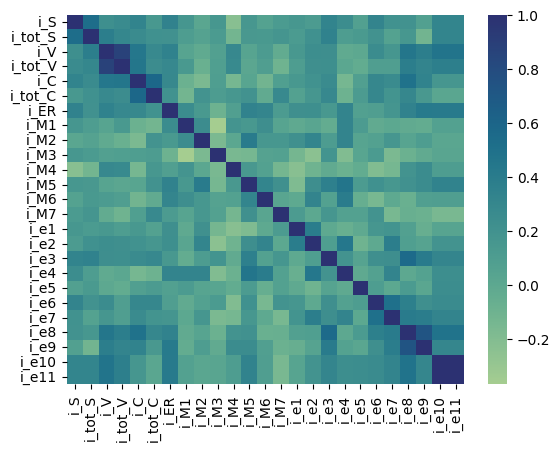

In [5]:
sns.heatmap(df_indexes_pd.iloc[:, 1:].corr(), cmap="crest")

In [6]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
    display(df_indexes_pd.iloc[:, 1:].corr()[df_indexes_pd.iloc[:, 1:].corr() >= 0.5])

,i_S,i_tot_S,i_V,i_tot_V,i_C,...,i_e7,i_e8,i_e9,i_e10,i_e11
i_S,1.000000,0.531063,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
i_tot_S,0.531063,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
i_V,NaN,NaN,1.000000,0.875353,NaN,...,NaN,NaN,NaN,NaN,NaN
i_tot_V,NaN,NaN,0.875353,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN
i_C,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
i_e7,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN
i_e8,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000000,0.734964,NaN,NaN
i_e9,NaN,NaN,NaN,NaN,NaN,...,NaN,0.734964,1.000000,NaN,NaN
i_e10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,1.0


array([[<Axes: xlabel='i_S', ylabel='i_S'>,
        <Axes: xlabel='i_tot_S', ylabel='i_S'>,
        <Axes: xlabel='i_V', ylabel='i_S'>,
        <Axes: xlabel='i_tot_V', ylabel='i_S'>,
        <Axes: xlabel='i_C', ylabel='i_S'>,
        <Axes: xlabel='i_tot_C', ylabel='i_S'>],
       [<Axes: xlabel='i_S', ylabel='i_tot_S'>,
        <Axes: xlabel='i_tot_S', ylabel='i_tot_S'>,
        <Axes: xlabel='i_V', ylabel='i_tot_S'>,
        <Axes: xlabel='i_tot_V', ylabel='i_tot_S'>,
        <Axes: xlabel='i_C', ylabel='i_tot_S'>,
        <Axes: xlabel='i_tot_C', ylabel='i_tot_S'>],
       [<Axes: xlabel='i_S', ylabel='i_V'>,
        <Axes: xlabel='i_tot_S', ylabel='i_V'>,
        <Axes: xlabel='i_V', ylabel='i_V'>,
        <Axes: xlabel='i_tot_V', ylabel='i_V'>,
        <Axes: xlabel='i_C', ylabel='i_V'>,
        <Axes: xlabel='i_tot_C', ylabel='i_V'>],
       [<Axes: xlabel='i_S', ylabel='i_tot_V'>,
        <Axes: xlabel='i_tot_S', ylabel='i_tot_V'>,
        <Axes: xlabel='i_V', ylabel='i_tot_V'

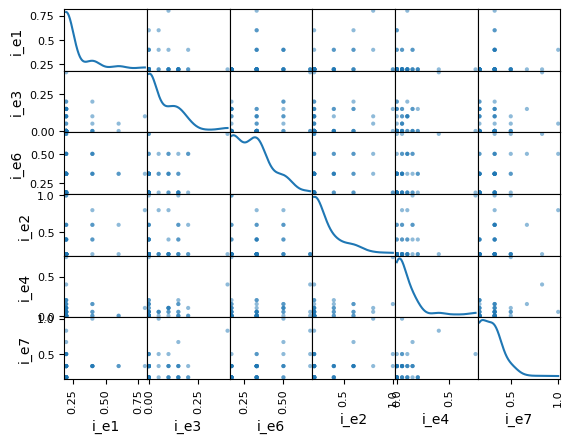

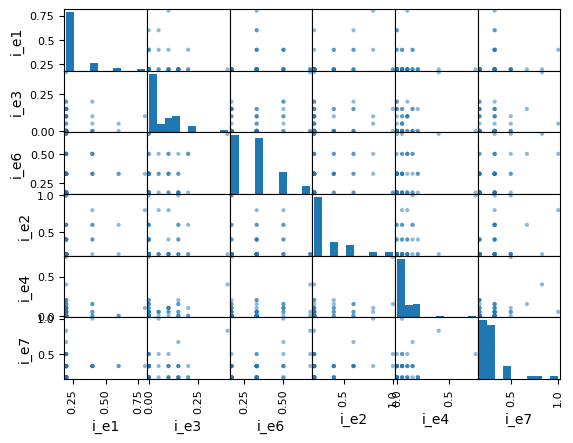

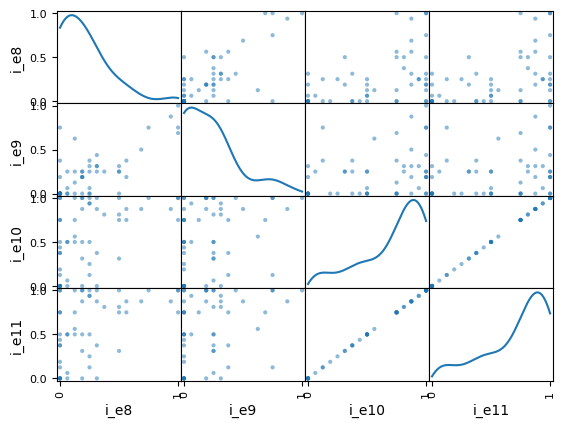

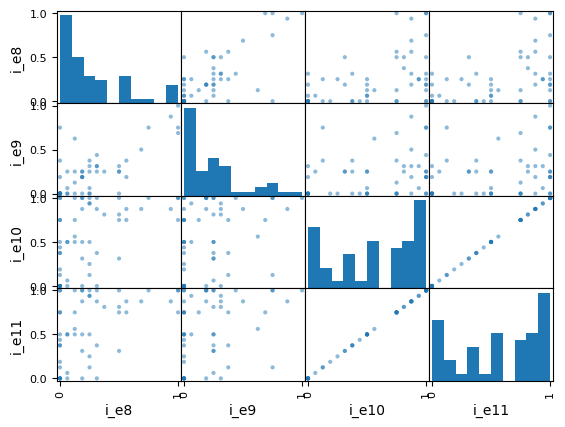

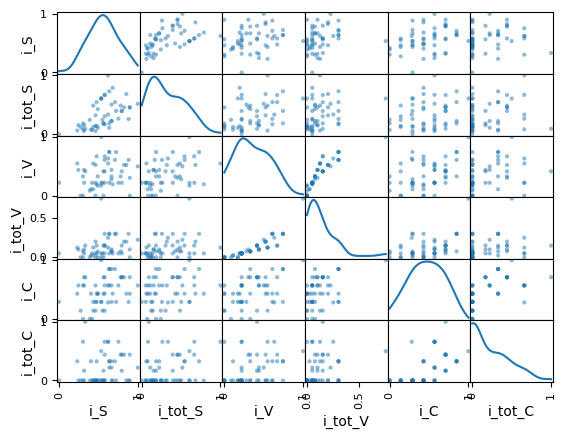

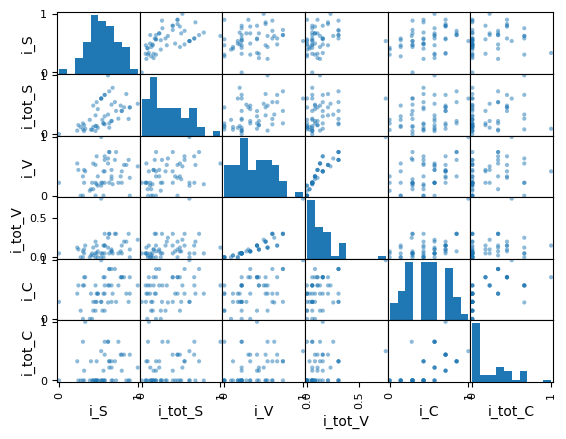

In [7]:
scatter_matrix(df_indexes_pd[['i_e1', 'i_e3', 'i_e6', 'i_e2', 'i_e4', 'i_e7']], diagonal='kde')
scatter_matrix(df_indexes_pd[['i_e1', 'i_e3', 'i_e6', 'i_e2', 'i_e4', 'i_e7']], diagonal='hist')

scatter_matrix(df_indexes_pd[['i_e8', 'i_e9', 'i_e10', 'i_e11']], diagonal='kde')
scatter_matrix(df_indexes_pd[['i_e8', 'i_e9', 'i_e10', 'i_e11']], diagonal='hist')

scatter_matrix(df_indexes_pd[['i_S', 'i_tot_S', 'i_V', 'i_tot_V', 'i_C', 'i_tot_C']], diagonal='kde')
scatter_matrix(df_indexes_pd[['i_S', 'i_tot_S', 'i_V', 'i_tot_V', 'i_C', 'i_tot_C']], diagonal='hist')

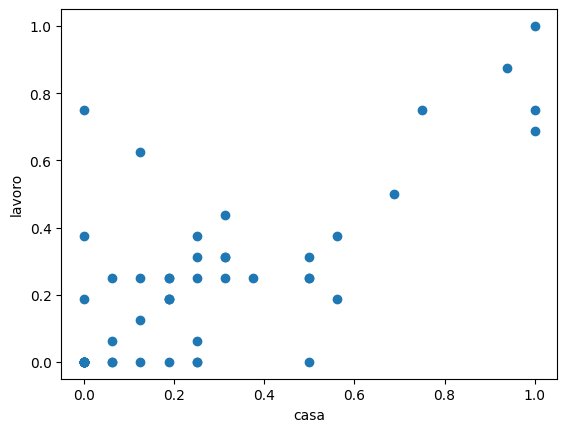

In [8]:
fig, ax = plt.subplots()
plt.xlabel('casa')
plt.ylabel('lavoro')
ax.scatter(df_indexes_pd['i_e8'], df_indexes_pd['i_e9'])

## Collaborative Filtering

In [16]:
model = run_collaborative_filtering(spark, df_indexes_pd)

user_recs = model.recommendForAllUsers(52).toPandas()
items_recs = model.recommendForAllItems(25).toPandas()

# round the recommendation scores to 2 decimal digits
round_cf_df(items_recs).tail(5)

Root-mean-square error = 2.9996594895348627


,feature_id,recommendations
21,7,"[(17, 0.79), (33, 0.73), (48, 0.72), (32, 0.51..."
22,8,"[(3, 0.88), (16, 0.8), (21, 0.73), (20, 0.72),..."
23,18,"[(27, 0.38), (31, 0.22), (28, 0.19), (46, 0.18..."
24,19,"[(47, 1.08), (3, 0.95), (36, 0.94), (45, 0.93)..."
25,9,"[(22, 1.03), (27, 0.95), (16, 0.95), (38, 0.95..."


## K-means

In [10]:
run_kmeans(spark, df_indexes_pd.iloc[:, 1:])

[array([0.63972727, 0.39186364, 0.47177273, 0.18072727, 0.53727273,
        0.23222727, 0.40663636, 0.36486364, 0.62045455, 0.90909091,
        0.11154545, 0.22727273, 0.47727273, 0.45181818, 0.25454545,
        0.42727273, 0.09090909, 0.12727273, 0.43563636, 0.35636364,
        0.38590909, 0.42613636, 0.358     , 0.85222727, 0.85222727]),
 array([0.557     , 0.48957143, 0.44771429, 0.11428571, 0.46857143,
        0.17242857, 0.17442857, 0.30128571, 0.64285714, 0.91428571,
        0.06171429, 0.10714286, 0.03571429, 0.47      , 0.22857143,
        0.25714286, 0.07142857, 0.04285714, 0.82142857, 0.33285714,
        0.26285714, 0.23214286, 0.15171429, 0.884     , 0.884     ]),
 array([0.48521739, 0.2253913 , 0.233     , 0.06730435, 0.40347826,
        0.17973913, 0.15217391, 0.28813043, 0.57043478, 0.89565217,
        0.09756522, 0.04347826, 0.19565217, 0.44152174, 0.25217391,
        0.26086957, 0.02608696, 0.03043478, 0.35873913, 0.26130435,
        0.23956522, 0.10865217, 0.14130435, 

In [11]:
clusters = pd.read_csv("../data/clusters.csv").iloc[:, 1:]
display(clusters[clusters['cluster_idx'] == 0].head(3))
display(clusters[clusters['cluster_idx'] == 1].head(3))
display(clusters[clusters['cluster_idx'] == 2].head(3))

,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,i_M3,...,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11,cluster_idx
0,0.623,0.333,0.634,0.25,0.28,0.66,0.389,0.796,1.00,0.6,...,0.05,0.05,0.25,0.17,0.17,0.188,0.25,0.312,0.312,0
1,0.493,0.106,0.171,0.00,0.43,0.00,0.000,0.120,0.33,1.0,...,0.00,0.00,0.00,0.33,0.33,0.000,0.00,0.000,0.000,0
2,0.333,0.091,0.415,0.15,0.71,1.00,0.444,0.120,1.00,1.0,...,0.00,0.05,0.25,0.17,0.33,0.062,0.25,0.062,0.062,0


,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,i_M3,...,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11,cluster_idx
23,0.304,0.182,0.329,0.076,0.00,0.00,0.444,0.599,1.00,1.0,...,0.00,0.10,0.00,0.17,0.33,0.125,0.250,1.000,1.000,1
24,0.638,0.109,0.220,0.050,0.57,0.22,0.278,0.150,1.00,0.8,...,0.05,0.05,0.50,0.33,0.50,0.250,0.312,0.938,0.938,1
25,0.884,0.258,0.610,0.300,0.29,0.00,0.278,0.120,0.75,1.0,...,0.10,0.10,0.25,0.50,0.17,0.500,0.312,0.812,0.812,1


,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,i_M3,...,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11,cluster_idx
41,0.826,0.456,0.524,0.20,0.71,0.440,0.556,0.599,0.4,1.0,...,0.10,0.10,0.50,0.50,0.50,0.688,0.500,0.875,0.875,2
42,0.638,0.729,0.744,0.30,0.85,0.327,0.667,0.299,0.5,0.8,...,0.15,0.00,0.25,0.33,0.17,0.938,0.875,0.875,0.875,2
43,0.536,0.606,1.000,0.75,1.00,0.500,0.000,0.479,0.4,1.0,...,0.15,0.05,0.25,0.17,0.33,0.562,0.188,0.875,0.875,2


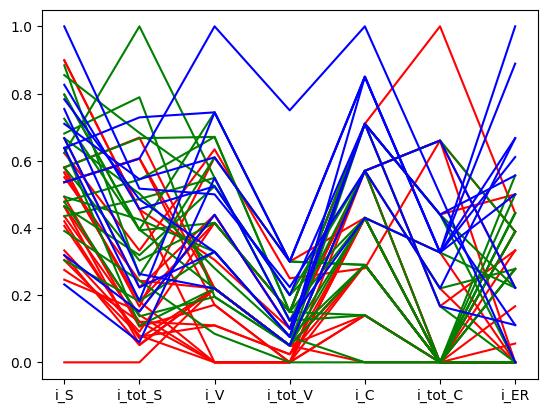

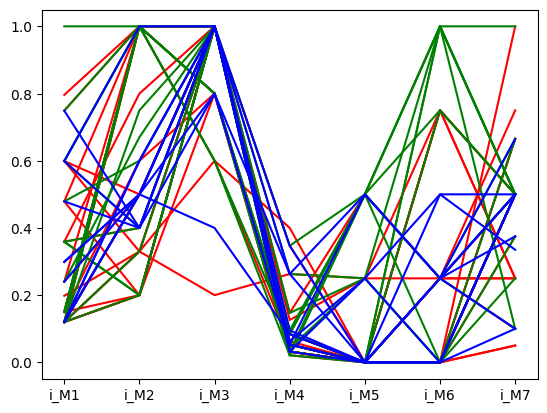

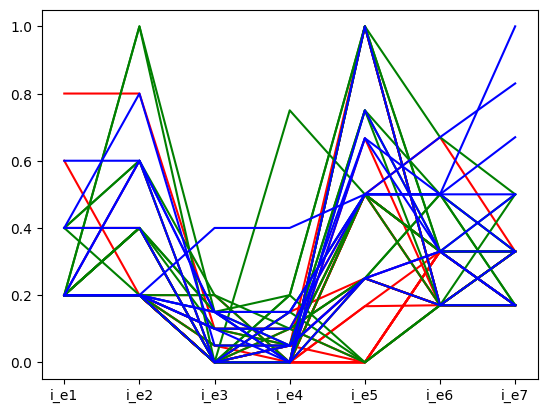

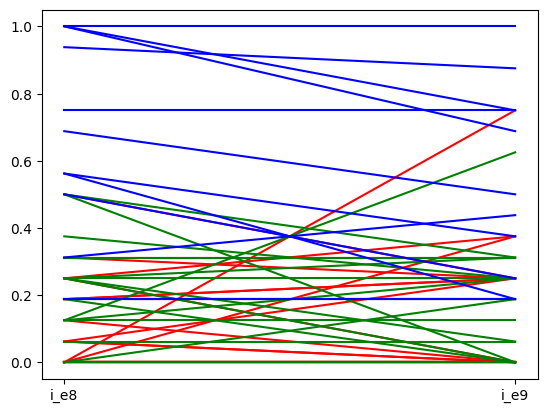

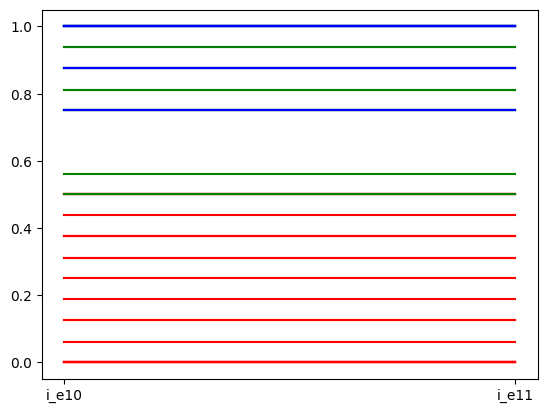

In [12]:
cols = [
    ["i_S", "i_tot_S", "i_V", "i_tot_V", "i_C", "i_tot_C", "i_ER"],
    ["i_M1", "i_M2", "i_M3", "i_M4", "i_M5", "i_M6", "i_M7"],
    ["i_e1", "i_e2", "i_e3", "i_e4", "i_e5", "i_e6", "i_e7"],
    ["i_e8", "i_e9"],
    ["i_e10", "i_e11"],
]

for c in cols:
    plt.plot(clusters[c][clusters["cluster_idx"] == 0].T, color="red")
    plt.plot(clusters[c][clusters["cluster_idx"] == 1].T, color="green")
    plt.plot(clusters[c][clusters["cluster_idx"] == 2].T, color="blue")

    plt.show()

In [13]:
avg = pd.read_csv("../data/clusters_means.csv")
avg

,cluster_idx,i_S,i_tot_S,i_V,i_tot_V,i_C,i_tot_C,i_ER,i_M1,i_M2,...,i_e2,i_e3,i_e4,i_e5,i_e6,i_e7,i_e8,i_e9,i_e10,i_e11
0,0,0.657889,0.437278,0.533222,0.205556,0.648333,0.292722,0.382722,0.294556,0.519444,...,0.344444,0.102778,0.066667,0.560222,0.380000,0.380000,0.520889,0.385500,0.906222,0.906222
1,1,0.485217,0.225391,0.233000,0.067304,0.403478,0.179739,0.152174,0.288130,0.570435,...,0.260870,0.026087,0.030435,0.358739,0.261304,0.239565,0.108652,0.141304,0.214652,0.214652
2,2,0.557364,0.379727,0.355909,0.097818,0.311818,0.095182,0.298000,0.439455,0.800000,...,0.454545,0.059091,0.172727,0.477273,0.302727,0.317273,0.147636,0.181727,0.784091,0.784091


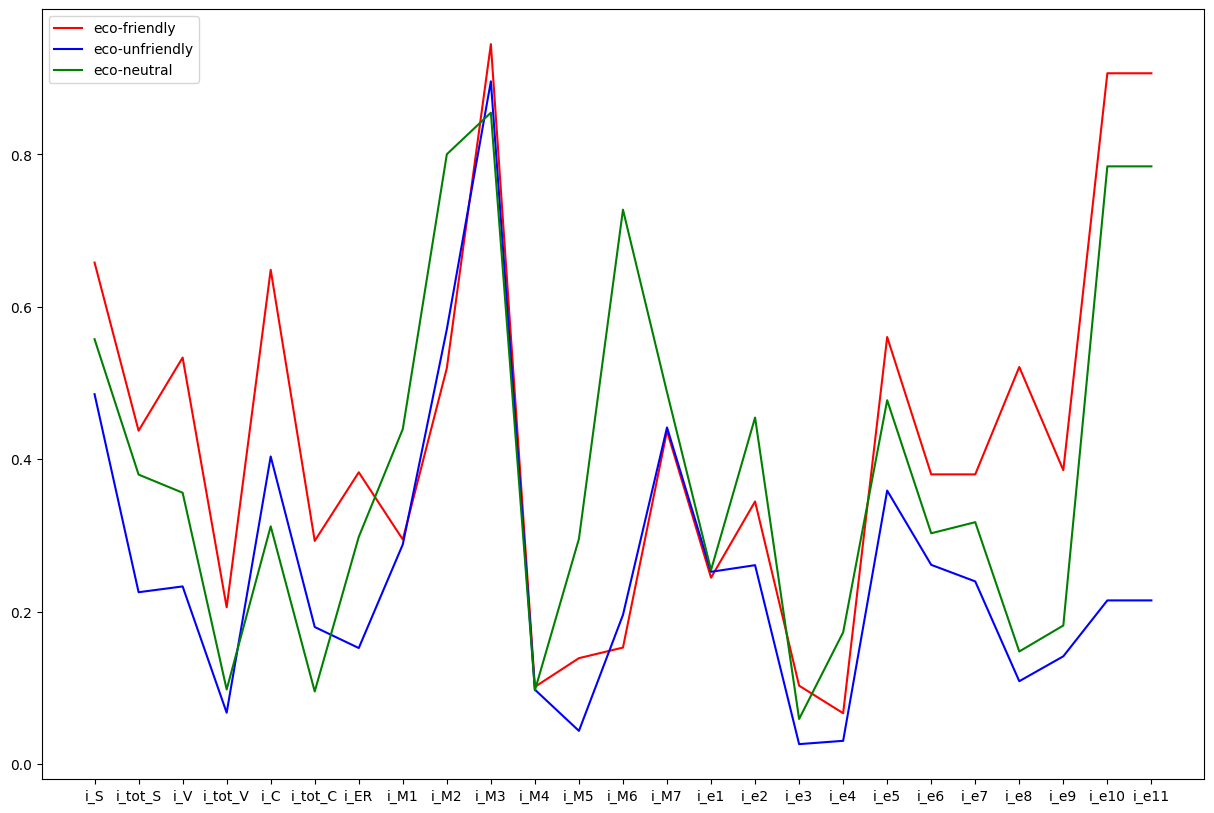

In [14]:
zero, ones, twos = avg.loc[0], avg.loc[1], avg.loc[2]

plt.figure(figsize=(15, 10))

colors = ["red", "blue", "green"]
avgs = [zero[1:], ones[1:], twos[1:]]
labels = ['eco-friendly', 'eco-unfriendly', 'eco-neutral']
for i in range(len(avgs)):
    plt.plot(avgs[i], color=colors[i], label=labels[i])

plt.legend()
plt.show()